In [77]:
#Importing Packages
#Basic
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import random
import subprocess


#Networks
import networkx as ntx

#Visualizing Tool
from graph_tool.all import *
import graph_tool.draw as gd
import graph_tool.centrality as gc
import cairo

#Fractal Dimension
import json
from scipy.stats import linregress

#Make Log File
print(os.getcwd())
#os.chdir('')
log_name = './log.txt'
print(os.getcwd())

/home/starrysky/Documents/SNU2019_FreshmanSeminar/FreshmanSeminar
/home/starrysky/Documents/SNU2019_FreshmanSeminar/FreshmanSeminar


In [4]:
#Generate output png file name
def png_namegen(dtype='FB', gtype='ESpS', BAedge=None, wtype=None, eps=None, cutoff = None):
    name = './graphs/'+gtype+'/'+('_'.join([dtype,gtype]))
    if BAedge: name = '_'.join([name,'BA',str(BAedge)])
    if wtype: name = '_'.join([name,'wtype',wtype])
    if eps: name = '_'.join([name,'eps','{:.1e}'.format(eps)])
    if cutoff: name = '_'.join([name,'cut',str(cutoff)])
    name += '.png'
    return name

print(png_namegen(wtype='plus',eps=0.03, cutoff=5))#dhk
print(png_namegen(dtype = 'GR', gtype='ESpT'))
print(png_namegen(dtype = 'BAN', gtype='ESpT', BAedge=4))

./graphs/ESpS/FB_ESpS_wtype_plus_eps_3.0e-02_cut_5.png
./graphs/ESpT/GR_ESpT.png
./graphs/ESpT/BAN_ESpT_BA_4.png


In [5]:
#Generate output histogram file name
def hist_namegen(dtype='FB', htype='degree', BAedge=None, st=None, wtype=None, breaks=None, rang=None):
    name = './histograms/'+htype+'/'+('_'.join([dtype,htype]))
    if BAedge: name = '_'.join([name,'BA',str(BAedge)])
    if st: name = '_'.join([name,'st',str(st)])
    if wtype: name = '_'.join([name,'wtype',wtype])
    if breaks: name = '_'.join([name,'breaks',str(breaks)])
    if rang: name = '_'.join([name,'range','{:.1e}'.format(rang)])
    name += '.png'
    return name

print(hist_namegen(dtype='FB',htype='degree'))
print(hist_namegen(dtype='FB',htype='degree',st=200))
print(hist_namegen(dtype='GR',htype='weight',wtype='plus',breaks=100, rang=0.025))

./histograms/degree/FB_degree.png
./histograms/degree/FB_degree_st_200.png
./histograms/weight/GR_weight_wtype_plus_breaks_100_range_2.5e-02.png


In [6]:
def adjlist_namegen(dtype='FB', gtype='ESpS', BAedge=None, wtype=None, eps=None, cutoff = None):
    name = './AdjList/'+gtype+'/'+('_'.join([dtype,gtype]))
    if BAedge: name = '_'.join([name,'BA',str(BAedge)])
    if wtype: name = '_'.join([name,'wtype',wtype])
    if eps: name = '_'.join([name,'eps','{:.1e}'.format(eps)])
    if cutoff: name = '_'.join([name,'cut',str(cutoff)])
    name += '.txt'
    return name

print(adjlist_namegen(wtype='plus',eps=0.03, cutoff=5))#dhk
print(adjlist_namegen(dtype = 'GR', gtype='ESpT'))
print(adjlist_namegen(dtype = 'BAN', gtype='ESpT', BAedge=4))

./AdjList/ESpS/FB_ESpS_wtype_plus_eps_3.0e-02_cut_5.txt
./AdjList/ESpT/GR_ESpT.txt
./AdjList/ESpT/BAN_ESpT_BA_4.txt


In [7]:
def json_decode(fname = './'):
    with open(fname, 'r') as json_file:
        json_data = json.load(json_file)
        return json_data

In [8]:
#Get FB Dataset
FB = np.loadtxt(fname = './facebook_combined.txt', delimiter=' ', comments='#', dtype=int)
print(FB)
print(len(FB))

[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [4027 4032]
 [4027 4038]
 [4031 4038]]
88234


In [9]:
#Get Rel Dataset
GR = np.loadtxt(fname = './CA-GrQc.txt', delimiter='\t', comments='#', dtype=int)
print(len(GR))

28980


In [10]:
#Draw Degree Histogram
def getdeg(G,breaks=None,st=0, output=None):
    deg = {}
    for p in G:
        #print(p[0], p[1])
        if deg.get(p[0]) is None:
            deg[p[0]] = 1
        if deg.get(p[1]) is None:
            deg[p[1]] = 1
        deg[p[0]] = deg[p[0]] + 1
        deg[p[1]] = deg[p[1]] + 1
#print(deg)
    n = max(deg.values())
    print(n)
    H = [0] * (n + 1)
    for v in deg.values():
        H[v] = H[v] + 1
    print(H[0])
    X = np.arange(st,n+1)
    if not breaks:
        breaks = len(X)
    _ = plt.hist(X, bins = breaks, weights=H[st:n+1])
    if output: plt.savefig(fname=output)

163
0


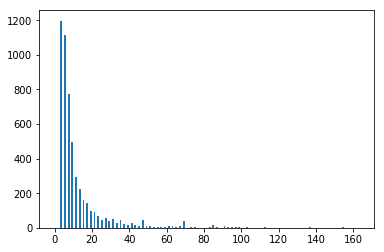

In [8]:
getdeg(GR, output=hist_namegen(dtype='GR',htype='degree'))


163
0


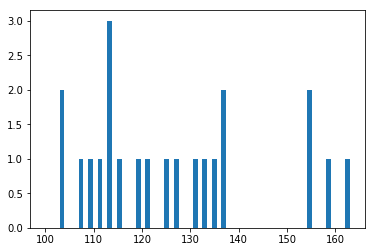

In [9]:
getdeg(GR, st=100, output=hist_namegen(dtype='GR',htype='degree', st=100))

1046
0


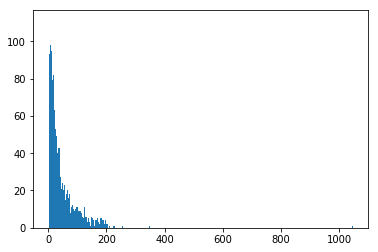

In [10]:
getdeg(FB, output=hist_namegen(dtype='FB',htype='degree'))

1046
0


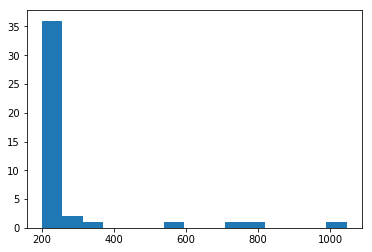

In [11]:
getdeg(FB, breaks=15, st = 200, output=hist_namegen(dtype='FB',htype='degree', st=200, breaks=15))

In [11]:
#Dehash and Get Adjacency List
def dehash_and_listize(G, undir = True):
    hasher = []
    for e in G:
        hasher.append(e[0])
        hasher.append(e[1])
    hasher = list(set(hasher))
    print(hasher[:50])
    dehasher = {}
    for i, h in enumerate(hasher):
        dehasher[h] = i 
    
    n = len(hasher)
    adj_G = [[] for _ in range(n)]
    for e in G:
        if e[0] == e[1]: continue
        adj_G[dehasher[e[0]]].append(dehasher[e[1]])
        if not undir:
            adj_G[dehasher[e[1]]].append(dehasher[e[0]])
    #print(type(G))
    return hasher, adj_G

hasher_GR,adjlist_GR = dehash_and_listize(GR, undir = True)
hasher_FB,adjlist_FB = dehash_and_listize(FB, undir = False)
#print(hasher_A[:-20:-1])
#print(max(dehashed_A.reshape(-1)))
#for i in range(20):
#    print(hasher_A[i],end = ' : ')
#    for j in adjlist_A[i]:
#        print(hasher_A[j], end=' ')
#    print()


[8193, 24578, 8195, 16389, 24582, 24583, 8200, 16393, 8198, 24587, 24589, 8206, 13, 8208, 24592, 24594, 8211, 24595, 24597, 24593, 8215, 24, 8216, 26, 8219, 27, 29, 16414, 8222, 8224, 24601, 25, 28, 16415, 24614, 8231, 24616, 24617, 24615, 24620, 45, 46, 16429, 16433, 62, 8254, 24640, 65, 8255, 8261]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [12]:
def export(adj_L, filename):
    n = len(adj_L)
    f = open(filename, 'w')
    for i in range(n):
        for j in adj_L[i]:
            f.write(str(i) + ' ' + str(j) + '\n')
    f.close()

#export(adjlist_GR, 'GR_dehashed.txt')

In [13]:
#Calculate Global Efficiency w/ AdjList
def calc_efficiencies(adj_L):
    n = len(adj_L)
    dis = [[n + 1] * n for _ in range(n)]
    for source in range(n):
        if source % 500 == 0:
            print(source)
        D = dis[source]
        D[source] = 0
        Q = deque([])
        Q.append(source)
        while len(Q) > 0:
            f = Q.popleft()
            for u in adj_L[f]:
                if D[u] > D[f] + 1:
                    D[u] = D[f] + 1
                    Q.append(u)
    
    glob_eff = 0
    for i in range(n):
        for j in range(i+1,n):
            if dis[i][j] == n + 1:
                continue
            glob_eff += 1 / dis[i][j]
            
    glob_eff /= n * (n-1) // 2
    print('global efficiency : ', glob_eff)
    
    return glob_eff, dis

In [14]:
GR_ge, GR_dis = calc_efficiencies(adjlist_GR) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
global efficiency :  0.11283474592043267


In [11]:
FB_ge,FB_dis = calc_efficiencies(adjlist_FB)

0
500
1000
1500
2000
2500
3000
3500
4000
global efficiency :  0.3065781479571354


In [14]:
#Generate Erdos-Renyl Random Graph w/ |V|=n, prob=p
def erdos_renyi(n = 5000, p = 0.5):
    adj_L = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                adj_L[i].append(j)
                adj_L[j].append(i)
    return adj_L

test_adj = erdos_renyi(10,0.3)
print(test_adj)

[[2, 4, 5, 7], [4, 6, 8], [0, 3, 4, 6, 7], [2], [0, 1, 2, 7, 9], [0, 7, 9], [1, 2, 7], [0, 2, 4, 5, 6], [1, 9], [4, 5, 8]]


In [41]:
#Erdos-Renyi graph with p = 0.01
rndgph_erdos = erdos_renyi(5000,0.01)
#_,__ = calc_efficiencies(rndgph_erdos)

In [42]:
#p = 0.005
rndgphs_erdos_2 = erdos_renyi(5000,0.005)
#_,__ = calc_efficiencies(rndgphs_erdos_2)

In [15]:
#Generate Modified Small-World Network w/ |V|=n+hubs, short edge:pick from 2k & prob=b, long edge = add, #hub = hubs, deg(hubs)=n*phub
def small_world_network(n = 5000, k = 20, b = 0.5, add = 0, hubs = 0, phub = 0.1):    
    # 2kb ~ mean deg, add : additional random edge 
    G = [[] for _ in range(n + hubs)]
    for i in range(n):
        for j in range(1,k+1):
            if random.random() < b:
                t = (i+j)%n
                G[i].append(t)
                G[t].append(i)
    S = set()
    while len(S) < add:
        i = random.randint(0,n-1)
        j = random.randint(i+k+1,i+n-k-1)
        j %= n
        if i > j:
            i, j = j, i
        S.add((i,j))
    #print(S)
    for elem in S:
        G[elem[0]].append(elem[1])
        G[elem[1]].append(elem[0])
    
    hubset = [i for i in range(n)]
    for i in range(hubs):
        random.shuffle(hubset)
        for j in range(int(len(hubset) * phub)):
            G[hubset[j]].append(n + i)
            G[n + i].append(hubset[j])
        hubset.append(n + i)
    return G

adj_swn = small_world_network(20, 3, 0.7,3, 3, 0.8)
print(adj_swn)

[[1, 3, 17, 18, 19, 4, 20, 21], [0, 3, 18, 19, 20, 21, 22], [4, 5, 19, 20, 21], [0, 1, 5, 6, 16, 20, 21, 22], [2, 5, 6, 7, 0, 20], [2, 3, 4, 6, 7, 8, 20, 22], [3, 4, 5, 7, 8, 9, 20, 21, 22], [4, 5, 6, 10, 20, 21, 22], [5, 6, 20, 21, 22], [6, 10, 11, 18, 21], [7, 9, 12, 20, 22], [9, 12, 13, 14, 20, 21, 22], [10, 11, 13, 14, 21, 22], [11, 12, 14, 15, 16, 21, 22], [11, 12, 13, 16, 17, 20, 21, 22], [13, 17, 18, 20, 22], [13, 14, 17, 18, 3, 20, 21, 22], [14, 15, 16, 18, 0, 20], [15, 16, 17, 0, 1, 9, 21, 22], [0, 1, 2, 20, 21, 22], [10, 15, 17, 11, 4, 16, 14, 0, 19, 6, 7, 1, 8, 3, 5, 2, 21, 22], [12, 20, 8, 0, 7, 9, 6, 16, 3, 1, 2, 11, 14, 18, 13, 19, 22], [5, 14, 11, 10, 12, 8, 19, 20, 15, 6, 7, 18, 3, 16, 21, 13, 1]]


In [18]:
adj_swn2 = small_world_network(n = 5000, k = 30, b = 0.25, add = 100)

_, __ = calc_efficiencies(adj_swn2)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.14505624859201063


In [19]:
adj_swn3 = small_world_network(n = 5000, k = 30, b = 0.25, add = 0)
_, __ = calc_efficiencies(adj_swn3)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.051725884005002574


In [20]:
adj_swn4 = small_world_network(n = 5000, k = 30, b = 0.25, add = 200)
_, __ = calc_efficiencies(adj_swn4)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.16494393993505355


In [16]:
adj_swn_with_add = small_world_network(n = 5000, k = 30, b = 0.5, add = 100)
#_, __ = calc_efficiencies(adj_swn_with_add)

In [17]:
adj_swn_with_hub = small_world_network(n = 5000, k = 30, b = 0.5, 
                                       add = 100, hubs = 40, phub = 0.04)
#_, __ = calc_efficiencies(adj_swn_with_hub)

In [18]:
#Generate Scale-Free Network with Barabasi-Albert model w/ |V|=n, |E|=mn (new node: m edges)
def barabasi_albert(n = 5000, m=4):
    G = ntx.barabasi_albert_graph(n=n, m=m)
    adj = ntx.to_dict_of_lists(G)
    adj_L = [[] for _ in range(n)]
    for i in range(n):
        adj_L[i] = adj[i]
    return adj_L

test_adj = barabasi_albert(10,3)
print(test_adj)



[[3, 4, 6], [9, 3, 4, 5, 7], [8, 9, 3, 4, 5], [0, 1, 2, 5, 6, 9], [0, 1, 2, 6, 7], [1, 2, 3], [0, 8, 3, 4, 7], [8, 1, 4, 6], [2, 6, 7], [1, 2, 3]]


In [19]:
adj_ban_1 = barabasi_albert(5000,1)
adj_ban_2 = barabasi_albert(5000,2)
adj_ban_3 = barabasi_albert(5000,3)
adj_ban_4 = barabasi_albert(5000,4)
adj_ban_5 = barabasi_albert(5000,5)
adj_ban_6 = barabasi_albert(5000,6)
adj_ban_7 = barabasi_albert(5000,7)
adj_ban_8 = barabasi_albert(5000,8)
adj_ban_9 = barabasi_albert(5000,9)
adj_ban_10 = barabasi_albert(5000,10)
#_, __ = calc_efficiencies(adj_ban_4)

In [20]:
#Calculate Local Efficiency w/ AdjList
def local_efficiencies(adj_L, use_log = True):
    n = len(adj_L)
    print("n = ", n)
    adj_M = [[False]*n for _ in range(n)]
    for i in range(n):
        for j in adj_L[i]:
            adj_M[i][j] = True
    tot_loc_eff = 0
    var_loc_eff = 0
    for source in range(n):
        if source % 500 == 0:
            print(source)
        B = adj_L[source]
        k = len(B)
        if k == 0:
            print("I'm a nerd!!!!!!")
            continue
        dis = [[k + 1] * k for _ in range(k)]
        for i in range(k):
            dq = deque([i])
            D = dis[i]
            D[i] = 0
            while len(dq) > 0:
                f = dq.popleft()
                for j in range(len(B)):
                    if not adj_M[B[i]][B[j]] or D[j] <= D[i] + 1:
                        continue
                    D[j] = D[i] + 1
                    dq.append(j)
        loc_eff = 0
        for i in range(k):
            for j in range(i+1, k):
                if dis[i][j] == k + 1:
                    continue
                loc_eff += 1 / dis[i][j]
        if k > 1:
            loc_eff /= k * (k-1) / 2
        tot_loc_eff += loc_eff
        var_loc_eff += loc_eff ** 2
    tot_loc_eff /= n
    var_loc_eff = var_loc_eff / n - tot_loc_eff ** 2
    print("Local efficiency : ", tot_loc_eff, "\nVariance : ", var_loc_eff)
    if use_log :
        f = open(log_name, 'at')
        f.write("Local efficiency : {0:.3f}\nVariance : {1:.3f}\n".
                format(tot_loc_eff, var_loc_eff))
        f.close()
    
    return tot_loc_eff, var_loc_eff

_, __ = local_efficiencies(adj_swn)

n =  23
0
Local efficiency :  0.572004018998904 
Variance :  0.022995892285525288


In [24]:
local_efficiencies(adjlist_FB)

n =  4039
0
500
1000
1500
2000
2500
3000
3500
4000
Local efficiency :  0.6055467186200871 
Variance :  0.045982642409736096


(0.6055467186200871, 0.045982642409736096)

In [228]:
local_efficiencies(adj_swn_with_add)

n =  5000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
Local efficiency :  0.3671347393568415 
Variance :  0.0008877088058748261


(0.3671347393568415, 0.0008877088058748261)

In [25]:
local_efficiencies(adj_swn_with_hub)

n =  5040
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
Local efficiency :  0.3313984752913302 
Variance :  0.0020918851844959063


(0.3313984752913302, 0.0020918851844959063)

In [172]:
local_efficiencies(adjlist_GR)

n =  5242
0
500
1000
1500
2000
2500
I'm a nerd!!!!!!
3000
3500
4000
4500
5000
Local efficiency :  0.5296358110521359 
Variance :  0.1837682859163694


(0.5296358110521359, 0.1837682859163694)

In [92]:
local_efficiencies(adj_ban_4)

n =  5000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
Local efficiency :  0.010592755909383968 
Variance :  0.0013388829086156426


(0.010592755909383968, 0.0013388829086156426)

In [21]:
import inspect
from graph_tool.draw.graphviz_draw import *
from graph_tool.generation import *
#inspect.getmembers(gd)
#inspect.getmembers(graph_tool)

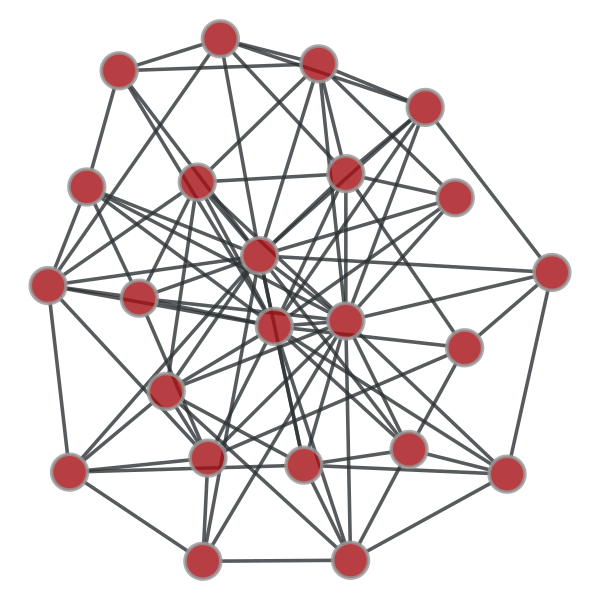

U R an idiot! hahaha!


In [22]:
#Visualize Graph w/ AdjList
def draw_network(adj_L, pos = None, output = None):
    g = Graph(directed = False)
    n = len(adj_L)
    vlist = g.add_vertex(n)
    for i in range(n):
        for j in adj_L[i]:
            if i > j:
                continue
            e = g.add_edge(g.vertex(i), g.vertex(j))
    if not pos:
        pos = gd.sfdp_layout(g)
    graph_draw(g,pos=pos,output=output)
    #ret = g.new_vertex_property("vector<double>")
    #return pos
draw_network(adj_swn)#,output="./graphs/idiot.png")
#draw_network(adj_swn,pos = pos_tmp, output="./graphs/moron.png")
print('U R an idiot! hahaha!')

In [188]:
draw_network(adjlist_GR, output=png_namegen(dtype='GR',gtype='Raw'))

In [189]:
draw_network(adjlist_FB, output=png_namegen(dtype='FB',gtype='Raw'))

In [190]:
draw_network(adj_swn_with_hub, output=png_namegen(dtype='SWNwH',gtype='Raw'))

In [191]:
draw_network(adj_swn_with_add, output=png_namegen(dtype='SWNwA',gtype='Raw'))

In [114]:
draw_network(adj_ban_4, output=png_namegen(dtype='BAN',gtype='Raw', BAedge=4))

In [23]:
#UnionFind  ///  Trim Network w.r.t. size of Conn.Comp. (Only Strictly Greater) w/ AdjList & cutoff
def uf_parent(x, par):
    if par[x] == x:
        return x
    else:
        par[x] = uf_parent(par[x], par)
        return par[x]

def uf_merge(x, y, par, sz):
    x = uf_parent(x, par)
    y = uf_parent(y, par)
    if x != y:
        par[y] = x
        sz[x] += sz[y]
        return True
    return False

def trim_network(adj_L, cutoff = 20):
    sys.setrecursionlimit(10**6)
    n = len(adj_L)
    par = [i for i in range(n)]
    sz = [1] * n
    for i in range(n):
        for j in adj_L[i]:
            uf_merge(i, j, par, sz)
    
    v_tr = []
    for i in range(n):
        if sz[uf_parent(i,par)] > cutoff:
            v_tr.append(i)
    
    hasher = [-1] * n
    for i, v in enumerate(v_tr):
        hasher[v] = i
    
    ret_L = []
    for v in v_tr:
        x = []
        for u in adj_L[v]:
            x.append(hasher[u])
        ret_L.append(x[:])
    
    return ret_L

In [24]:
adjlist_GR_tr = trim_network(adjlist_GR)
#draw_network(adjlist_GR_tr, output=png_namegen(dtype='GR',gtype='Trim',cutoff=20))

In [25]:
adjlist_FB_tr = trim_network(adjlist_FB)
#draw_network(adjlist_FB_tr, output=png_namegen(dtype='FB',gtype='Trim',cutoff=20))

In [26]:
#Generate Minimal W Spanning Tree w.r.t. Large Deg -> Low Weight.   w/ AdjList & weight_type = 'plus'/'max'
#Generate Spanning Graph w.r.t. Trim Edges with Small Deg.   w/ AdjList & cutoff & weight_type = 'plus'/'max'
def elitism_spanning_tree(adj_L, weight_type='plus'):
    n = len(adj_L)
    deg = [len(adj_L[i]) for i in range(n)]
    adj_sp = [[] for _ in range(n)]
    par = [i for i in range(n)]
    sz = [1] * n
    
    weighted_edges = []
    for i in range(n):
        for j in adj_L[i]:
            if i < j: continue
            weight = 1/(deg[i] + deg[j]) if weight_type == 'plus' else 1/max(deg[i],deg[j])
            weighted_edges.append((weight, i, j))
    
    weighted_edges.sort(key = lambda t : t[0])
    print('edges : ', len(weighted_edges))
    for w in weighted_edges:
        if uf_merge(w[1], w[2], par, sz):
            #print('connecting ',w[1],w[2])
            adj_sp[w[1]].append(w[2])
            adj_sp[w[2]].append(w[1])
    return adj_sp

def elitism_spanning_subgraph(adj_L, cutoff = 0.1, weight_type='plus'):
    n = len(adj_L)
    deg = [len(adj_L[i]) for i in range(n)]
    adj_sp = [[] for _ in range(n)]
    
    weighted_edges = []
    for i in range(n):
        for j in adj_L[i]:
            if i < j: continue
            weight = 1/(deg[i] + deg[j]) if weight_type == 'plus' else 1/max(deg[i],deg[j])
            weighted_edges.append((weight, i, j))
    
    weighted_edges.sort(key = lambda t : t[0])
    print('edges : ', len(weighted_edges))
    for w in weighted_edges:
        if w[0] > cutoff:
            break
        adj_sp[w[1]].append(w[2])
        adj_sp[w[2]].append(w[1])
    return adj_sp

In [27]:
adjlist_GR_sp = elitism_spanning_tree(adjlist_GR_tr)
#draw_network(adjlist_GR_sp, output=png_namegen(dtype='GR',gtype='ESpT', wtype = 'plus'))

edges :  13422


In [28]:
#Trim Edges with Small Deg -> Trim Vertices with small Conn.Comp. size
adjlist_GR_spg = trim_network(elitism_spanning_subgraph(adjlist_GR_tr, cutoff = 0.02))
#draw_network(adjlist_GR_spg)

edges :  13422


In [29]:
adjlist_FB_sp = elitism_spanning_tree(adjlist_FB_tr)
#draw_network(adjlist_FB_sp, output=png_namegen(dtype='FB',gtype='ESpT', wtype='plus'))

edges :  88234


In [30]:
adjlist_FB_spg = trim_network(elitism_spanning_subgraph(adjlist_FB_tr, cutoff = 0.02))
#draw_network(adjlist_FB_spg)

edges :  88234


In [31]:
adjlist_SWNwH_sp = elitism_spanning_tree(adj_swn_with_hub)
#draw_network(adjlist_SWNwH_sp, output=png_namegen(dtype='SWNwH',gtype='ESpT', wtype='plus'))

edges :  83224


In [165]:
adjlist_SWNwA_sp = elitism_spanning_tree(adj_swn_with_add)
#draw_network(adjlist_SWNwA_sp, output=png_namegen(dtype='SWNwA',gtype='ESpT', wtype='plus'))

edges :  75125


In [32]:
adjlist_BAN_4_sp = elitism_spanning_tree(adj_ban_4)
#draw_network(adjlist_BAN_4_sp, output=png_namegen(dtype='BAN',gtype='ESpT', BAedge=4, wtype='plus'))

edges :  19984


In [33]:
adjlist_BAN_5_sp = elitism_spanning_tree(adj_ban_5)
#draw_network(adjlist_BAN_5_sp)

edges :  24975


In [34]:
adjlist_BAN_10_sp = elitism_spanning_tree(adj_ban_10)
#draw_network(adjlist_BAN_10_sp)

edges :  49900


In [199]:
for i in range(1, 10):
    eps = i*0.002
    tmp = trim_network(elitism_spanning_subgraph(adjlist_FB_tr, cutoff = eps),cutoff=5)
    print('eps = ',eps)
    draw_network(tmp, output=png_namegen(dtype='FB',gtype='ESpS', wtype='plus', eps=eps, cutoff = 5))

edges :  88234
eps =  0.002
edges :  88234
eps =  0.004
edges :  88234
eps =  0.006
edges :  88234
eps =  0.008
edges :  88234
eps =  0.01
edges :  88234
eps =  0.012
edges :  88234
eps =  0.014
edges :  88234
eps =  0.016
edges :  88234
eps =  0.018000000000000002


In [200]:
for i in range(1, 20):
    eps = i*0.002
    tmp = trim_network(elitism_spanning_subgraph(adjlist_GR_tr, cutoff = eps),cutoff=5)
    print('eps = ',eps)
    draw_network(tmp, output=png_namegen(dtype='GR',gtype='ESpS', wtype='plus', eps=eps, cutoff = 5))

edges :  13422
eps =  0.002
edges :  13422
eps =  0.004
edges :  13422
eps =  0.006
edges :  13422
eps =  0.008
edges :  13422
eps =  0.01
edges :  13422
eps =  0.012
edges :  13422
eps =  0.014
edges :  13422
eps =  0.016
edges :  13422
eps =  0.018000000000000002
edges :  13422
eps =  0.02
edges :  13422
eps =  0.022
edges :  13422
eps =  0.024
edges :  13422
eps =  0.026000000000000002
edges :  13422
eps =  0.028
edges :  13422
eps =  0.03
edges :  13422
eps =  0.032
edges :  13422
eps =  0.034
edges :  13422
eps =  0.036000000000000004
edges :  13422
eps =  0.038


In [201]:
for i in range(1, 10):
    eps = i*0.001
    tmp = trim_network(elitism_spanning_subgraph(adj_swn_with_hub, cutoff = eps),cutoff=5)
    print('eps = ',eps)
    draw_network(tmp, output=png_namegen(dtype='SWNwH',gtype='ESpS', wtype='plus', eps=eps, cutoff = 5))

edges :  83448
eps =  0.001
edges :  83448
eps =  0.002
edges :  83448
eps =  0.003
edges :  83448
eps =  0.004
edges :  83448
eps =  0.005
edges :  83448
eps =  0.006
edges :  83448
eps =  0.007
edges :  83448
eps =  0.008
edges :  83448
eps =  0.009000000000000001


In [113]:
for i in range(1, 10):
    eps = i*0.002
    tmp = trim_network(elitism_spanning_subgraph(adj_ban_4, cutoff = eps),cutoff=5)
    print('eps = ',eps)
    draw_network(tmp, output=png_namegen(dtype='BAN',gtype='ESpS', BAedge=4, wtype='plus', eps=eps, cutoff = 5))

edges :  19984
eps =  0.002
edges :  19984
eps =  0.004
edges :  19984
eps =  0.006
edges :  19984
eps =  0.008
edges :  19984
eps =  0.01
edges :  19984
eps =  0.012
edges :  19984
eps =  0.014
edges :  19984
eps =  0.016
edges :  19984
eps =  0.018000000000000002


In [35]:
#Draw Weight Histogram
def get_weight_spectra(adj_L,breaks = 10, rang=None, log = False, wtype='plus', output = None):
    n = len(adj_L)
    spec = [0] * (n+n+1)
    X = [0] + [1/(i+1) for i in range(2*n)]
    #X = np.arange(0, 2*n+1)
    for i in range(n):
        for j in adj_L[i]:
            w = len(adj_L[i]) + len(adj_L[j]) if wtype == 'plus' else max(len(adj_L[i]), len(adj_L[j]))
            if i<j: spec[w] += 1
    
    _ = plt.hist(X, bins = breaks, range = rang, log = log, weights=spec)
    if output: plt.savefig(output)

18
0


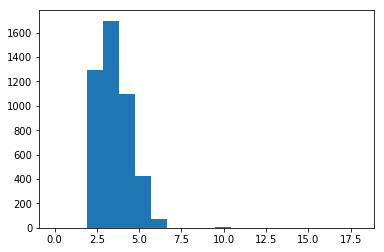

In [216]:
getdeg(adj_swn_with_hub, output=hist_namegen(dtype='SWNwH',htype='degree'))

124
0


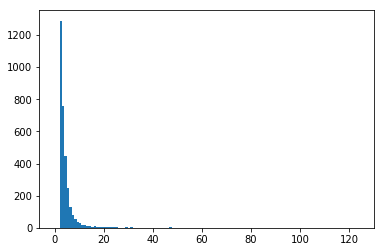

In [117]:
getdeg(adj_ban_4, output=hist_namegen(dtype='BAN',htype='degree', BAedge=4))

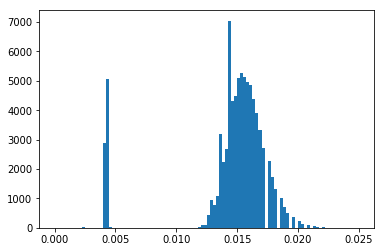

In [221]:
get_weight_spectra(adj_swn_with_hub, breaks = 100, rang=(0,0.025), output=hist_namegen(dtype='SWNwH',htype='weight',wtype='plus',breaks=100,rang=0.025))

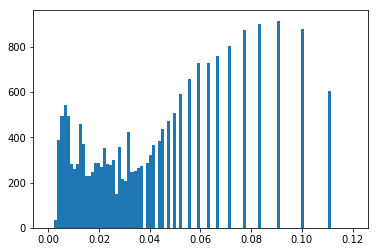

In [124]:
get_weight_spectra(adj_ban_4, breaks = 100, rang=(0,0.12), output=hist_namegen(dtype='BAN',htype='weight',wtype='plus',BAedge=4,breaks=100,rang=0.012))

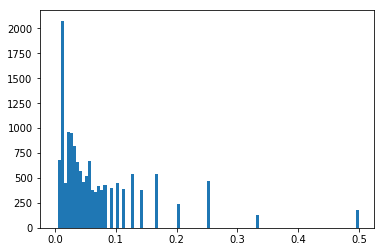

In [223]:
get_weight_spectra(adjlist_GR, breaks = 100, rang=(0,0.5), output=hist_namegen(dtype='GR',htype='weight',wtype='plus',breaks=100,rang=0.05))

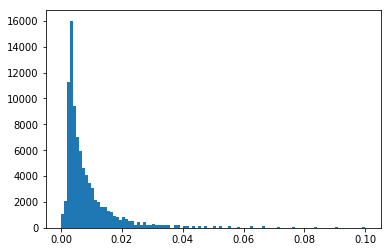

In [224]:
get_weight_spectra(adjlist_FB, breaks = 100, rang=(0,0.1), output=hist_namegen(dtype='FB',htype='weight',wtype='plus',breaks=100,rang=0.1))

In [76]:
export(adjlist_FB, filename = adjlist_namegen(dtype='FB', gtype='Raw'))
export(adjlist_GR, filename = adjlist_namegen(dtype='GR', gtype='Raw'))
export(adj_swn_with_add, filename = adjlist_namegen(dtype='SWNwA', gtype='Raw'))
export(adj_swn_with_hub, filename = adjlist_namegen(dtype='SWNwH', gtype='Raw'))
export(adj_ban_1, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=1))
export(adj_ban_2, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=2))
export(adj_ban_3, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=3))
export(adj_ban_4, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=4))
export(adj_ban_5, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=5))
export(adj_ban_6, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=6))
export(adj_ban_7, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=7))
export(adj_ban_8, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=8))
export(adj_ban_9, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=9))
export(adj_ban_10, filename=adjlist_namegen(dtype='BAN',gtype='Raw', BAedge=10))

In [72]:
export(adjlist_GR_tr, filename = adjlist_namegen(dtype='GR',gtype='Trim',cutoff=20))
export(adjlist_FB_tr, filename = adjlist_namegen(dtype='FB', gtype='Trim',cutoff = 20))

In [73]:
export(adjlist_GR_sp, filename=adjlist_namegen(dtype='GR',gtype='ESpT', wtype = 'plus'))
export(adjlist_FB_sp, filename=adjlist_namegen(dtype='FB',gtype='ESpT', wtype = 'plus'))
export(adjlist_SWNwH_sp, filename=adjlist_namegen(dtype='SWNwH',gtype='ESpT', wtype = 'plus'))
export(adjlist_BAN_4_sp, filename=adjlist_namegen(dtype='BAN',gtype='ESpT', BAedge=4, wtype='plus'))

ckpt :  0


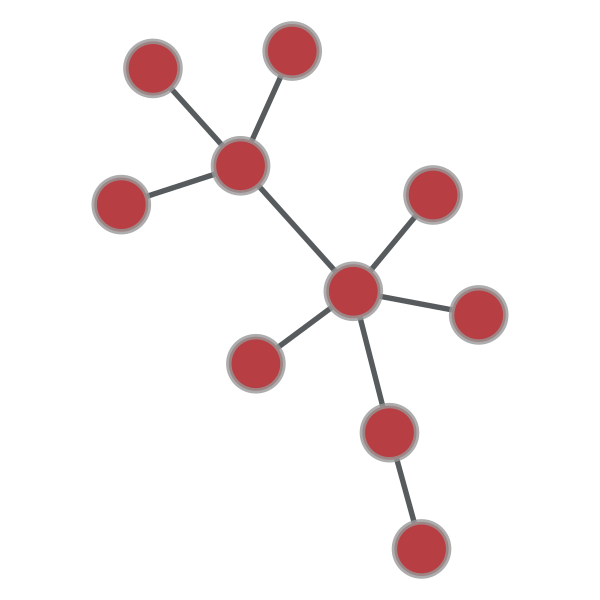

In [123]:
def skeleton(adj_L, draw = False, draw_all = False, pos = None, output = None):
    n = len(adj_L)
    M = [[0] * n for _ in range(n)]
    cnt = 0
    E = []
    
    for i in range(n):
        for j in adj_L[i]:
            if i > j: continue
            M[i][j] = M[j][i] = cnt
            E.append([i,j])
            cnt += 1
    #print(M)
    Bcen = [0] * cnt
    for i in range(n):
        if i % 500 == 0:
            print('ckpt : ', i)
        dq = deque([i])
        lev = [n] * n
        bfs_ord = []
        lev[i] = 0
        Bcen_v = [0] * n
        back = [[] for _ in range(n)]
        
        while len(dq):
            f = dq.popleft()
            bfs_ord.append(f)
            for s in adj_L[f]:
                if lev[s] < lev[f] + 1: continue
                if lev[s] == lev[f] + 1:
                    back[s].append(f)
                    continue
                back[s].append(f)
                lev[s] = lev[f] + 1
                dq.append(s)
        
        #print('source = ', i)
        for f in bfs_ord[::-1]:
            Bcen_v[f] += 1
            #print('id = ', f, 'Bcen = ', Bcen_v[f], 'lev = ', lev[f], 'back = ', back[f])
            if len(back[f]) == 0: continue
            Bcen_w = Bcen_v[f] / len(back[f])
            for s in back[f]:
                #print(M[f][s], '+= ', Bcen_w)
                Bcen[M[f][s]] += Bcen_w
                Bcen_v[s] += Bcen_w
    
    skel = [(Bcen[i], i) for i in range(cnt)]

    skel.sort(key = lambda t : -t[0])
    #print(skel)
    par = [i for i in range(n)]
    sz = [1] * n
    
    adj_skel = [[] for _ in range(n)]
    adj_nskel = [[] for _ in range(n)]
    for w in skel:
        a, b = E[w[1]]
        if uf_merge(a, b, par, sz):
            adj_skel[a].append(b)
            adj_skel[b].append(a)
        else:
            adj_nskel[a].append(b)
            adj_nskel[b].append(a)
    
    if not draw:
        return adj_skel
            
    g = Graph(directed = False)
    n = len(adj_L)
    vlist = g.add_vertex(n)
    be = g.new_edge_property("double")
    
    for i in range(n):
        for j in adj_skel[i]:
            if i > j:
                continue
            e = g.add_edge(g.vertex(i), g.vertex(j))
            be[e] = Bcen[M[i][j]]
            
    if not pos:
        pos = gd.sfdp_layout(g)
    if pos == 'arf':
        pos = gd.arf_layout(g)
    if draw_all:
        for i in range(n):
            for j in adj_nskel[i]:
                if i > j: continue
                e = g.add_edge(g.vertex(i), g.vertex(j))
                be[e] = Bcen[M[i][j]]
        
    be.a /= be.a.max() / 5
    graph_draw(g,pos=pos,edge_pen_width=be,output=output)
    
    return adj_skel

test_adj = barabasi_albert(10,3)
draw_network(skeleton(test_adj))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


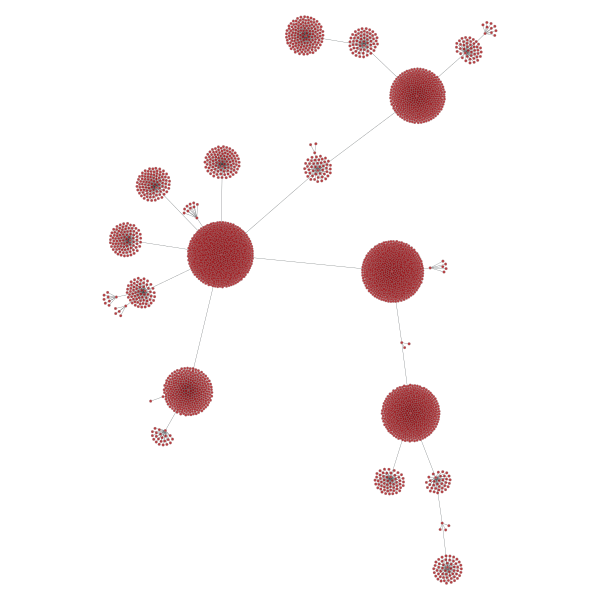

In [50]:
draw_network(skeleton(adjlist_FB))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500
ckpt :  5000


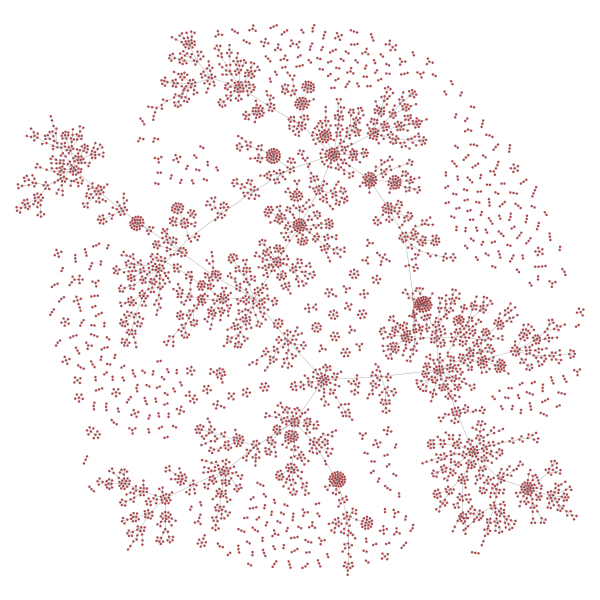

In [53]:
draw_network(skeleton(adjlist_GR))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


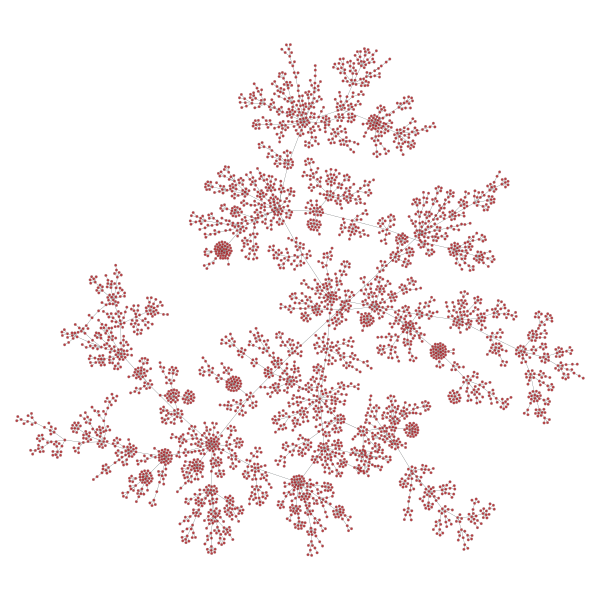

In [59]:
draw_network(skeleton(adjlist_GR_tr))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500
ckpt :  5000


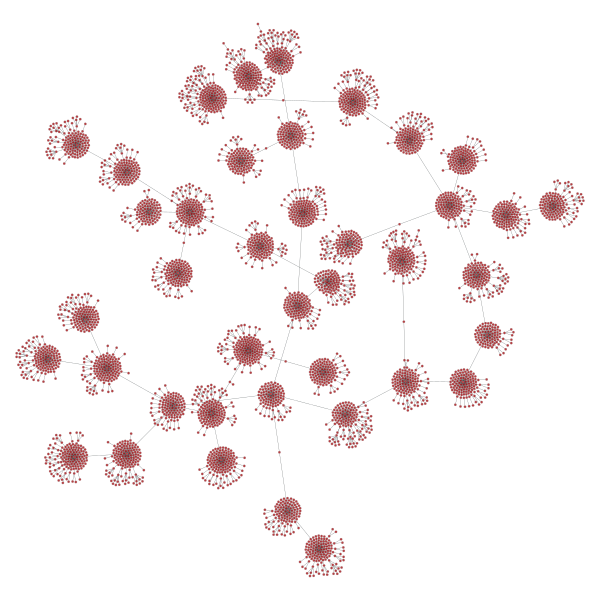

In [51]:
draw_network(skeleton(adj_swn_with_hub))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


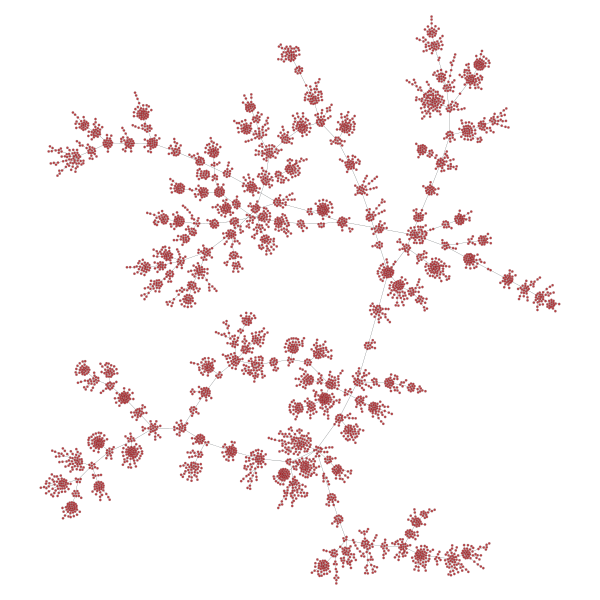

In [52]:
draw_network(skeleton(adj_swn_with_add))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


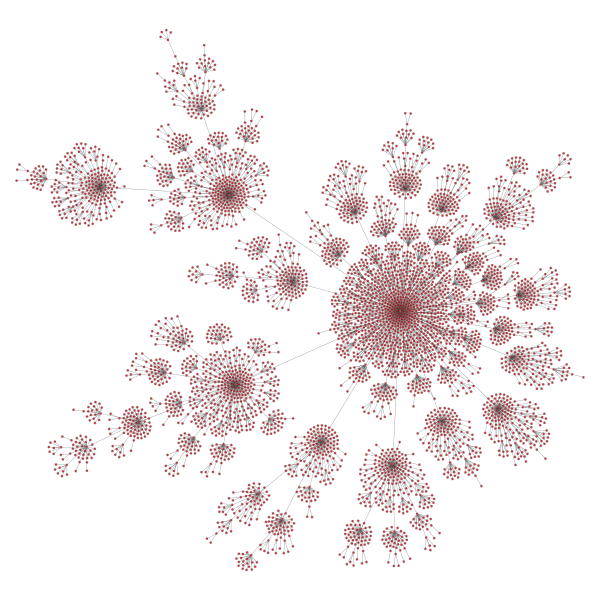

In [54]:
draw_network(skeleton(adj_ban_4))

In [82]:
path = './AdjList'
for dirname in os.listdir(path):
    if dirname[0] == '.':
        continue
    path_spec = os.path.join(path, dirname)
    #path_export_spec = os.path.join(path_export, dirname)
    for filename in os.listdir(path_spec):
        if filename.split('.')[1] != 'txt':
            continue
        #filename_export = os.path.join(path_export_spec, filename)
        filename_spec = os.path.join(path_spec, filename)
        subprocess.call(['../graph-sketch-fractality-master/bin/box_cover','-type=auto','-graph='+filename_spec,'-method=sketch','-random_seed=1124747'])

In [124]:
def jlog_linregress(fname = None, output=None):
    json_data = json_decode(fname)
    
    size = np.array(json_data['size'])
    rad = np.array(json_data['radius'])
    slope, intercept, r_value, p_value, std_err = linregress(np.log10(rad), np.log10(size))
    
    plt.plot(np.log10(rad), np.log10(size), 'k.', label='_nolegend_')
    plt.plot(np.log10(rad), np.log10(rad)*slope+intercept, label='y=''{:.3f}'.format(slope)+'x+''{:.3f}'.format(intercept))
    plt.title(json_data['run']['args'][2].split('/')[-1].split('.')[0])
    plt.xlabel('Log(rad)')
    plt.ylabel('Log(size)')
    for i in range(len(rad)):
        plt.annotate(size[i], (np.log10(rad)[i], np.log10(size)[i]))
    plt.legend()
    fig = plt.gcf()
    plt.show()
    if output:
        path_lin = ''.join(np.delete('/'.join(np.delete(json_data['run']['args'][2].split('/'),[0,1])).split('.'),-1))
        path_lin = './Fractal/'+path_lin+'.png'
        #print(path_lin)
        fig.savefig(path_lin)
    return slope

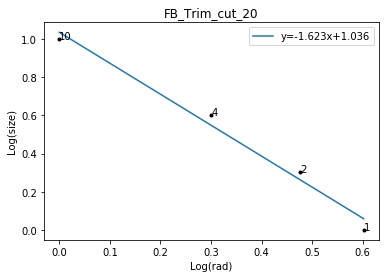

./Fractal/Trim/FB_Trim_cut_20.png
-1.6225428300761426


In [119]:
s = jlog_linregress('./box_cover.starrysky.jlog.191126-024826.4751', output=True)
print(s)

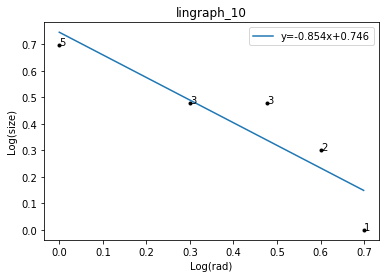

-0.8537386142766852


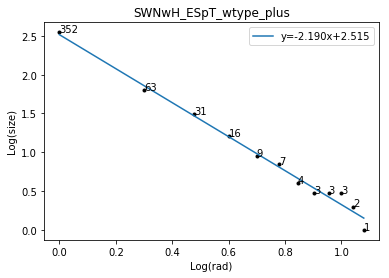

-2.1896501069867647


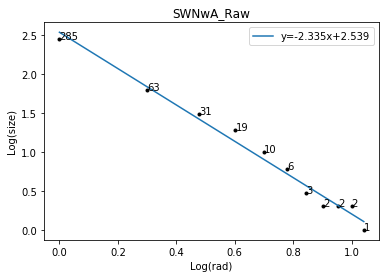

-2.3353018133875767


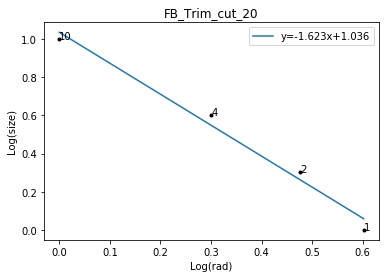

-1.6225428300761426


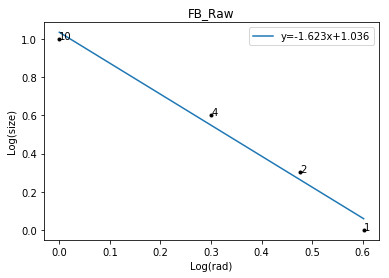

-1.6225428300761426


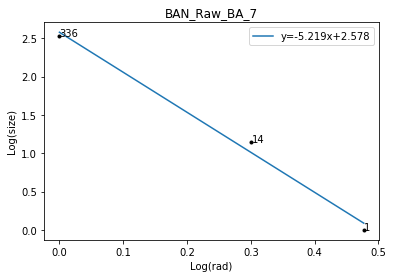

-5.218508489553978


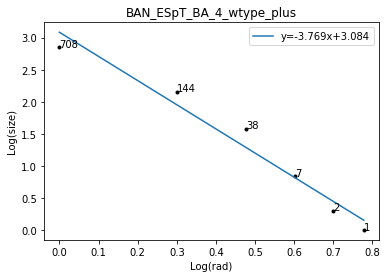

-3.7686097614389236


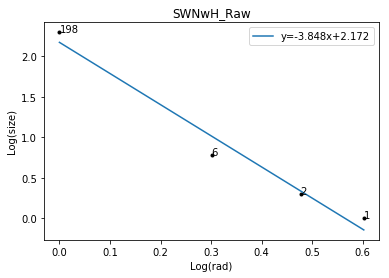

-3.8483759690842407


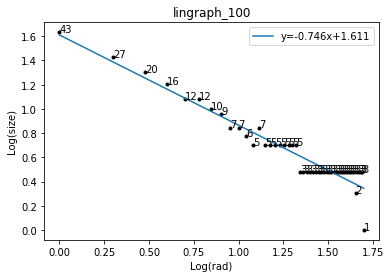

-0.7458031751415697


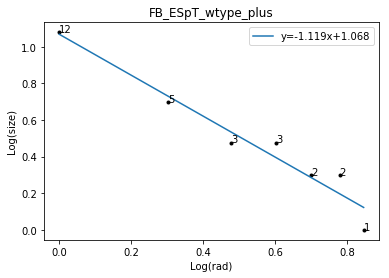

-1.118632451191387


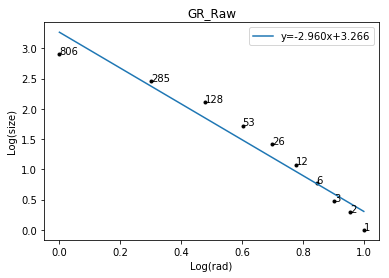

-2.9603188684568598


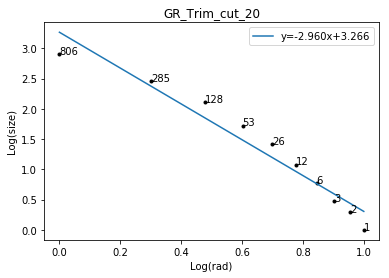

-2.9603188684568598


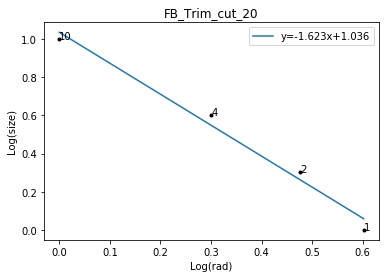

-1.6225428300761426


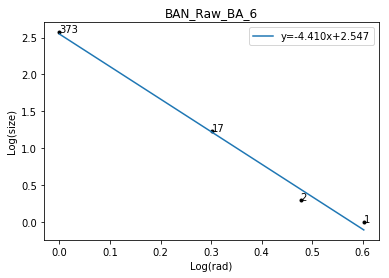

-4.40983927489644


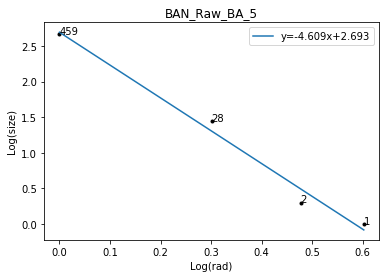

-4.608528186082282


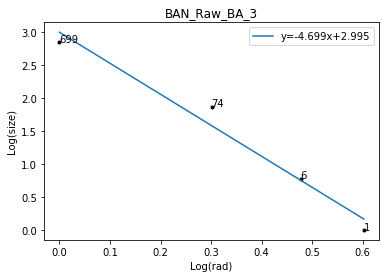

-4.699470150594464


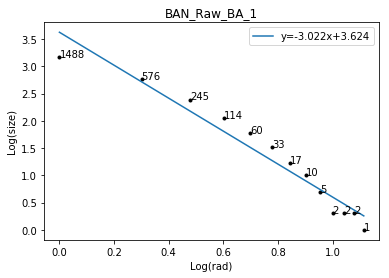

-3.0222305286551507


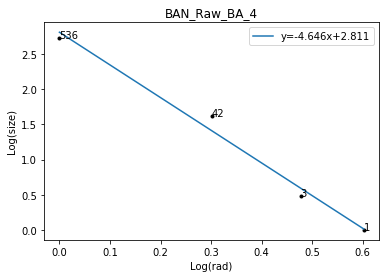

-4.646357946014714


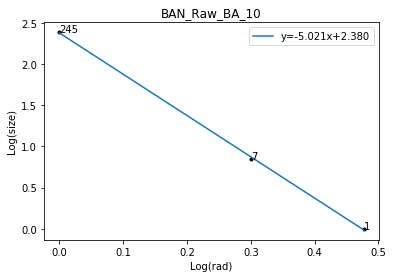

-5.020579059811956


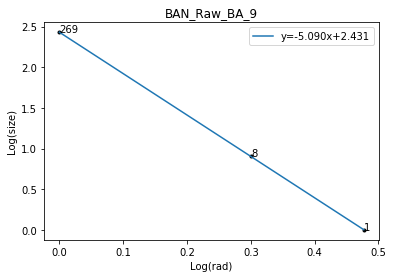

-5.090257609914039


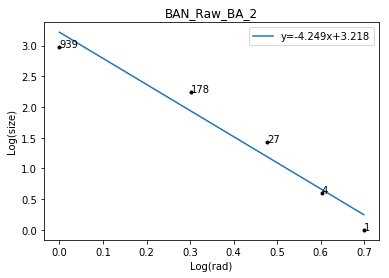

-4.248982250207774


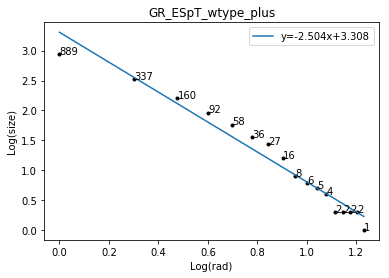

-2.50441485869768


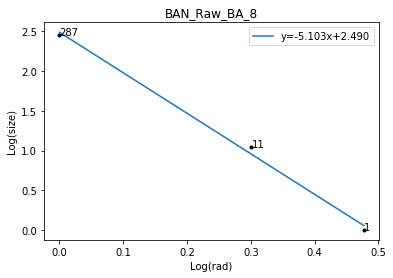

-5.103455729482509


In [121]:
path = './jlog'
for name in os.listdir(path):
    if 'jlog' not in name: continue
    full_name = os.path.join(path, name)
    s = jlog_linregress(full_name, output=True)
    print(s)

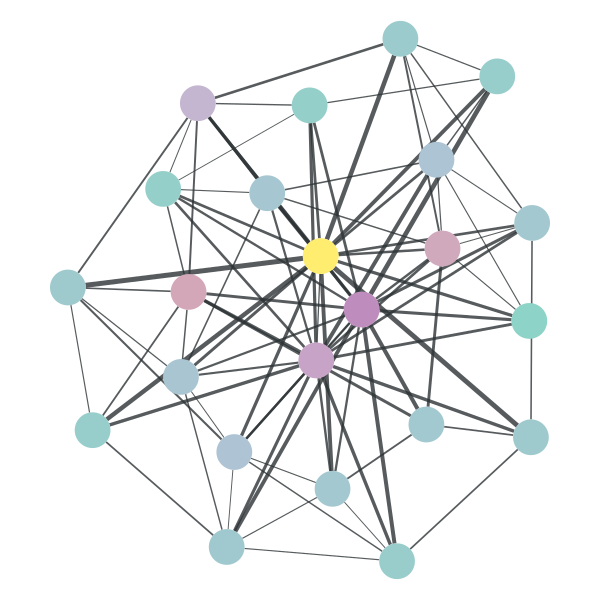

In [125]:
#Visualize Graph skeleton w/ AdjList
def draw_network_between(adj_L, pos = None, output = None):
    g = Graph(directed = False)
    n = len(adj_L)
    vlist = g.add_vertex(n)
    for i in range(n):
        for j in adj_L[i]:
            if i > j:
                continue
            e = g.add_edge(g.vertex(i), g.vertex(j))
    if not pos:
        pos = gd.sfdp_layout(g)
    
    bv, be = gc.betweenness(g)
    be.a /= be.a.max() / 5
    graph_draw(g,pos=pos,vertex_color=[1,1,1,0],vertex_fill_color=bv, edge_pen_width=be,output=output)
    #ret = g.new_vertex_property("vector<double>")
    #return pos
draw_network_between(adj_swn)

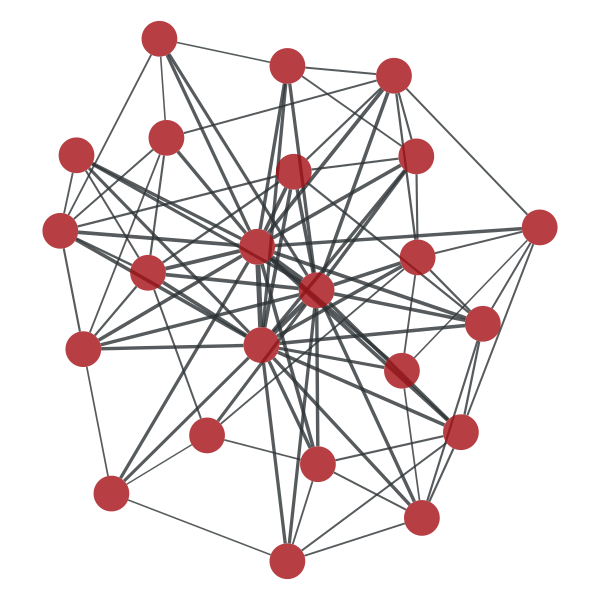

In [126]:
#Visualize Graph ESpT w/ AdjList
def draw_network_elitism(adj_L, pos = None, output = None):
    g = Graph(directed = False)
    n = len(adj_L)
    vlist = g.add_vertex(n)
    ewt = g.new_edge_property("double")
    for i in range(n):
        for j in adj_L[i]:
            if i > j:
                continue
            e = g.add_edge(g.vertex(i), g.vertex(j))
    if not pos:
        pos = gd.sfdp_layout(g)
    
    for i in range(n):
        for j in adj_L[i]:
            if i > j:
                continue
            e = g.edge(i,j)
            ewt[e] = (g.vertex(i).out_degree() + g.vertex(j).out_degree())
    #e = g.edges().next()
    #bv, be = gc.betweenness(g)
    ewt.a /= ewt.a.max() / 5
    graph_draw(g,pos=pos,vertex_color=[1,1,1,0], edge_pen_width=ewt,output=output)
    #ret = g.new_vertex_property("vector<double>")
    #return pos
draw_network_elitism(adj_swn)

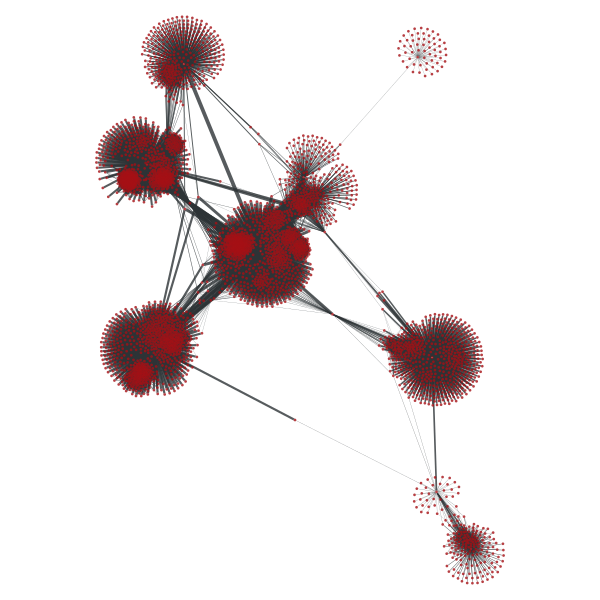

In [135]:
draw_network_elitism(adjlist_FB_spg)

In [142]:
draw_network_between(adjlist_FB, output=png_namegen(dtype='FB', gtype='BC', BAedge=None, wtype=None, eps=None, cutoff = None))

In [143]:
draw_network_between(adjlist_GR_tr, output=png_namegen(dtype='GR', gtype='BC', BAedge=None, wtype=None, eps=None, cutoff = None))

In [146]:
draw_network_between(adj_ban_4, output=png_namegen(dtype='BAN', gtype='BC', BAedge=4, wtype=None, eps=None, cutoff = None))

In [147]:
draw_network_between(adj_swn_with_hub, output=png_namegen(dtype='SWNwH', gtype='BC', BAedge=None, wtype=None, eps=None, cutoff = None))

In [148]:
draw_network_between(adj_swn_with_add, output=png_namegen(dtype='SWNwA', gtype='BC', BAedge=None, wtype=None, eps=None, cutoff = None))

In [149]:
_ = skeleton(adjlist_FB, draw = True, draw_all = True, output=png_namegen(dtype='FB', gtype='BCF', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


In [150]:
_ = skeleton(adjlist_GR_tr, draw = True, draw_all = True, output=png_namegen(dtype='GR', gtype='BCF', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


In [151]:
_ = skeleton(adj_ban_4, draw = True, draw_all = True, output=png_namegen(dtype='BAN', gtype='BCF', BAedge=4, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


In [152]:
_ = skeleton(adj_swn_with_hub, draw = True, draw_all = True, output=png_namegen(dtype='SWNwH', gtype='BCF', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500
ckpt :  5000


In [153]:
_ = skeleton(adj_swn_with_add, draw = True, draw_all = True, output=png_namegen(dtype='SWNwA', gtype='BCF', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


In [154]:
draw_network_elitism(adjlist_FB, output=png_namegen(dtype='FB', gtype='EW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [155]:
draw_network_elitism(adjlist_GR_tr, output=png_namegen(dtype='GR', gtype='EW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [156]:
draw_network_elitism(adj_ban_4, output=png_namegen(dtype='BAN', gtype='EW', BAedge=4, wtype='plus', eps=None, cutoff = None))

In [157]:
draw_network_elitism(adj_swn_with_hub, output=png_namegen(dtype='SWNwH', gtype='EW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [158]:
draw_network_elitism(adj_swn_with_add, output=png_namegen(dtype='SWNwA', gtype='EW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [159]:
draw_network_elitism(adjlist_FB_sp, output=png_namegen(dtype='FB', gtype='ESpTW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [160]:
draw_network_elitism(adjlist_GR_sp, output=png_namegen(dtype='GR', gtype='ESpTW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [162]:
draw_network_elitism(adjlist_BAN_4_sp, output=png_namegen(dtype='BAN', gtype='ESpTW', BAedge=4, wtype='plus', eps=None, cutoff = None))

In [163]:
draw_network_elitism(adjlist_SWNwH_sp, output=png_namegen(dtype='SWNwH', gtype='ESpTW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [166]:
draw_network_elitism(adjlist_SWNwA_sp, output=png_namegen(dtype='SWNwA', gtype='ESpTW', BAedge=None, wtype='plus', eps=None, cutoff = None))

In [167]:
_ = skeleton(adjlist_FB, draw = True, output=png_namegen(dtype='FB', gtype='SkelW', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


In [168]:
_ = skeleton(adjlist_GR_tr, draw = True, output=png_namegen(dtype='GR', gtype='SkelW', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


In [169]:
_ = skeleton(adj_ban_4, draw = True, output=png_namegen(dtype='BAN', gtype='SkelW', BAedge=4, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


In [170]:
_ = skeleton(adj_swn_with_hub, draw = True, output=png_namegen(dtype='SWNwH', gtype='SkelW', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500
ckpt :  5000


In [171]:
_ = skeleton(adj_swn_with_add, draw = True, output=png_namegen(dtype='SWNwA', gtype='SkelW', BAedge=None, wtype=None, eps=None, cutoff = None))

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000


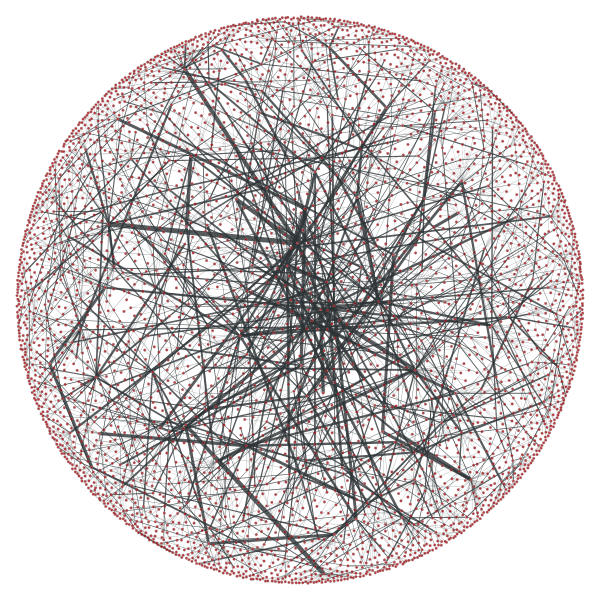

In [145]:
_ = skeleton(adjlist_GR_tr, draw = True, pos = "arf")

In [146]:
#_ = skeleton(adj_ban_4, draw = True, pos = 'arf')

ckpt :  0
ckpt :  500
ckpt :  1000
ckpt :  1500
ckpt :  2000
ckpt :  2500
ckpt :  3000
ckpt :  3500
ckpt :  4000
ckpt :  4500


SystemError: <built-in method translate of cairo.Context object at 0x7fc85683f3f0> returned NULL without setting an error